## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
#為了解決 model.fit 當掉問題
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[256, 128, 64]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [8]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.05]
redice_lr_patient = [5, 10]

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)

    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
hidden_layer3 (Dense)        (None, 64)                8256      
_________________________________________________________________
batch_normalizatio

50000/50000 [==============================] - 17s 332us/step - loss: 1.4131 - acc: 0.5012 - val_loss: 1.5298 - val_acc: 0.4643
Epoch 12/25
50000/50000 [==============================] - 16s 328us/step - loss: 1.3904 - acc: 0.5101 - val_loss: 1.5171 - val_acc: 0.4619
Epoch 13/25
50000/50000 [==============================] - 16s 327us/step - loss: 1.3705 - acc: 0.5176 - val_loss: 1.5054 - val_acc: 0.4694
Epoch 14/25
50000/50000 [==============================] - 17s 331us/step - loss: 1.3518 - acc: 0.5219 - val_loss: 1.4964 - val_acc: 0.4738
Epoch 15/25
50000/50000 [==============================] - 16s 319us/step - loss: 1.3307 - acc: 0.5314 - val_loss: 1.4971 - val_acc: 0.4723
Epoch 16/25
50000/50000 [==============================] - 17s 338us/step - loss: 1.3131 - acc: 0.5369 - val_loss: 1.4875 - val_acc: 0.4795
Epoch 17/25
50000/50000 [==============================] - 16s 320us/step - loss: 1.2963 - acc: 0.5449 - val_loss: 1.4842 - val_acc: 0.4748
Epoch 18/25
50000/50000 [=======

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 25s 510us/step - loss: 2.2780 - acc: 0.2538 - val_loss: 2.2754 - val_acc: 0.2861
Epoch 2/25
50000/50000 [==============================] - 16s 319us/step - loss: 1.8186 - acc: 0.3675 - val_loss: 1.8526 - val_acc: 0.3687
Epoch 3/25
50000/50000 [==============================] - 15s 305us/step - loss: 1.6970 - acc: 0.4049 - val_loss: 1.7399 - val_acc: 0.3964
Epoch 4/25
50000/50000 [==============================] - 17s 342us/step - loss: 1.6293 - acc: 0.4289 - val_loss: 1.6818 - val_acc: 0.4132
Epoch 5/25
50000/50000 [==============================] - 23s 453us/step - loss: 1.5834 - acc: 0.4445 - val_loss: 1.6353 - val_acc: 0.4293
Epoch 6/25
50000/50000 [==============================] - 21s 424us/step - loss: 1.5425 - acc: 0.4596 - val_loss: 1.6032 - val_acc: 0.4365
Epoch 7/25
50000/50000 [==============================] - 17s 335us/step - loss: 1.5096 - acc: 0.4707 - val_loss: 1.

50000/50000 [==============================] - 19s 370us/step - loss: 0.7550 - acc: 0.7455 - val_loss: 1.4915 - val_acc: 0.5071
Epoch 23/25
50000/50000 [==============================] - 18s 369us/step - loss: 0.7272 - acc: 0.7562 - val_loss: 1.4857 - val_acc: 0.5123
Epoch 24/25
50000/50000 [==============================] - 18s 366us/step - loss: 0.7156 - acc: 0.7587 - val_loss: 1.5414 - val_acc: 0.5043
Epoch 25/25
50000/50000 [==============================] - 18s 367us/step - loss: 0.7009 - acc: 0.7668 - val_loss: 1.5557 - val_acc: 0.5037
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_______________________________________________________________

50000/50000 [==============================] - 18s 370us/step - loss: 1.2658 - acc: 0.5616 - val_loss: 1.5328 - val_acc: 0.4603
Epoch 9/25
50000/50000 [==============================] - 19s 375us/step - loss: 1.2350 - acc: 0.5729 - val_loss: 1.5167 - val_acc: 0.4614
Epoch 10/25
50000/50000 [==============================] - 19s 381us/step - loss: 1.2076 - acc: 0.5814 - val_loss: 1.5120 - val_acc: 0.4692
Epoch 11/25
50000/50000 [==============================] - 18s 368us/step - loss: 1.1814 - acc: 0.5924 - val_loss: 1.4864 - val_acc: 0.4756
Epoch 12/25
50000/50000 [==============================] - 19s 372us/step - loss: 1.1576 - acc: 0.6006 - val_loss: 1.4615 - val_acc: 0.4956
Epoch 13/25
50000/50000 [==============================] - 19s 372us/step - loss: 1.1351 - acc: 0.6086 - val_loss: 1.4613 - val_acc: 0.4926
Epoch 14/25
50000/50000 [==============================] - 18s 363us/step - loss: 1.1109 - acc: 0.6154 - val_loss: 1.4860 - val_acc: 0.4812
Epoch 15/25
50000/50000 [========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 31s 622us/step - loss: 1.8058 - acc: 0.3674 - val_loss: 2.1260 - val_acc: 0.2921
Epoch 2/25
50000/50000 [==============================] - 16s 326us/step - loss: 1.5624 - acc: 0.4479 - val_loss: 4.0297 - val_acc: 0.1897
Epoch 3/25
50000/50000 [==============================] - 17s 336us/step - loss: 1.4697 - acc: 0.4805 - val_loss: 1.7823 - val_acc: 0.3797
Epoch 4/25
50000/50000 [==============================] - 17s 340us/step - loss: 1.4032 - acc: 0.5052 - val_loss: 2.0612 - val_acc: 0.3213
Epoch 5/25
50000/50000 [==============================] - 17s 333us/step - loss: 1.3555 - acc: 0.5241 - val_loss: 1.9414 - val_acc: 0.3259
Epoch 6/25
50000/50000 [==============================] - 17s 331us/step - loss: 1.3104 - acc: 0.5386 - val_loss: 1.9686 - val_acc: 0.3641
Epoch 7/25
50000/50000 [==============================] - 17s 334us/step - loss: 1.2688 - acc: 0.5574 - val_loss: 1.

50000/50000 [==============================] - 17s 331us/step - loss: 0.8481 - acc: 0.7084 - val_loss: 1.5794 - val_acc: 0.4673
Epoch 23/25
50000/50000 [==============================] - 17s 332us/step - loss: 0.8312 - acc: 0.7185 - val_loss: 1.5492 - val_acc: 0.4751
Epoch 24/25
50000/50000 [==============================] - 17s 331us/step - loss: 0.8165 - acc: 0.7227 - val_loss: 1.5383 - val_acc: 0.4845
Epoch 25/25
50000/50000 [==============================] - 17s 339us/step - loss: 0.8016 - acc: 0.7287 - val_loss: 1.6810 - val_acc: 0.4469
Numbers of exp: 10, reduce_factor: 0.05, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_______________________________________________________________

50000/50000 [==============================] - 17s 332us/step - loss: 1.7838 - acc: 0.3754 - val_loss: 1.8201 - val_acc: 0.3650
Epoch 9/25
50000/50000 [==============================] - 17s 343us/step - loss: 1.7556 - acc: 0.3845 - val_loss: 1.7963 - val_acc: 0.3733
Epoch 10/25
50000/50000 [==============================] - 16s 329us/step - loss: 1.7306 - acc: 0.3948 - val_loss: 1.7783 - val_acc: 0.3735
Epoch 11/25
50000/50000 [==============================] - 16s 326us/step - loss: 1.7075 - acc: 0.4029 - val_loss: 1.7596 - val_acc: 0.3786
Epoch 12/25
50000/50000 [==============================] - 17s 340us/step - loss: 1.6883 - acc: 0.4089 - val_loss: 1.7408 - val_acc: 0.3869
Epoch 13/25
50000/50000 [==============================] - 17s 331us/step - loss: 1.6698 - acc: 0.4162 - val_loss: 1.7262 - val_acc: 0.3950
Epoch 14/25
50000/50000 [==============================] - 17s 334us/step - loss: 1.6527 - acc: 0.4224 - val_loss: 1.7115 - val_acc: 0.3959
Epoch 15/25
50000/50000 [========

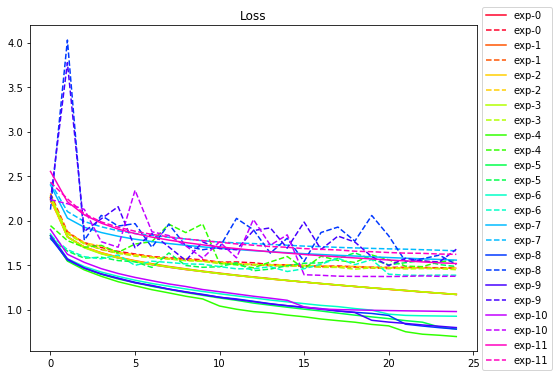

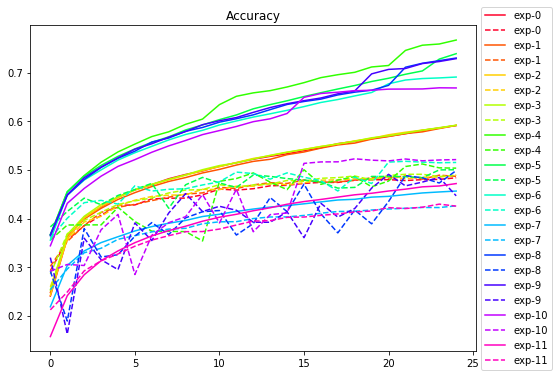

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()